# 집단감염 시각화

* 지도 시각화에 필요한 모듈들을 불러옵니다.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
        
import seaborn as sns
import matplotlib.pyplot as plt

import folium 
from folium import plugins
# from folium.plugins import HeatMap

import json 
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import webbrowser

* 지도 시각화에 사용할 데이터를 불러옵니다.  

In [51]:
path = os.getcwd()
fpopl = pd.read_csv(path[:-10]+'\\fpopl.csv')
#adstrd_master = pd.read_csv(path[:-10]+'\\adstrd_master.csv')
#region = pd.read_csv(path[:-10]+'\\COVID_19\\Region.csv')
case = pd.read_csv(path[:-10]+'\\COVID_19\\Case.csv')
#patient = pd.read_csv(path[:-10]+'\\COVID_19\\PatientInfo.csv')

데이터로부터 발생 지역, 감염유형, 확진자 수, 위도, 경도를 확인할 수 있습니다.  
맨 마지막의 size값은 바로 아래에서 설정한 대/중/소규모 집단 감염의 분류에 따라 대규모는 1, 중규모는 2, 소규모는 3으로 라벨링 된 값입니다.

In [91]:
data = case[['province','city','infection_case','confirmed','latitude','longitude','size']].dropna()
data

,province,city,infection_case,confirmed,latitude,longitude,size
0,대구,남구,Shincheonji Church,4511,35.84008,128.5667,1.0
1,대구,달성,Second Mi-Ju Hospital,196,35.857375,128.466651,1.0
2,서울,용산구,Itaewon Clubs,139,37.538621,126.992652,1.0
3,대구,서구,Hansarang Convalescent Hospital,124,35.885592,128.556649,1.0
4,경상북도,청도,Cheongdo Daenam Hospital,119,35.64887,128.7368,1.0
...,...,...,...,...,...,...,...
60,서울,양천구,Biblical Language study meeting,3,37.524623,126.843118,3.0
61,서울,중구,Seoul City Hall Station safety worker,3,37.565699,126.977079,3.0
62,전라남도,무안,Manmin Central Church,2,35.078825,126.316746,3.0
63,서울,강남구,Gangnam Dongin Church,1,37.522331,127.057388,3.0


확진환자 수에 따라 집단감염을 분류하기 위해 확진환자 수의 분포를 막대그래프로 표현하였습니다.  
확진환자 수는 아래와 같이 80, 25인 지점에서 큰 격차를 보였습니다. 따라서 이들을 기준으로 하여 80명 이상은 **대규모 집단 감염**, 25명 이상 80명 미만은 **중규모 집단 감염**, 25명 미만은 **소규모 집단 감염**으로 분류합니다.

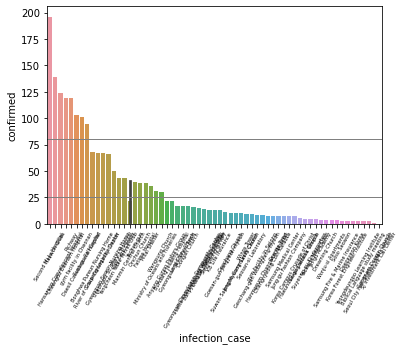

In [92]:
data.sort_values(by='confirmed')
icdata = data[['infection_case','confirmed']][1:]
sns.barplot(x='infection_case',y='confirmed',data=icdata)
plt.xticks(rotation=60, fontsize = 5)
plt.axhline(y=80, color='gray', linewidth=1)
plt.axhline(y=25, color='gray', linewidth=1)
plt.show()

분류한 집단별로 발생 위치와 감염의 크기를 지도에 시각화 하기 위해 세개의 데이터로 분류합니다.

In [93]:
data1 = data\
.query('size in ("1")').dropna()

data2 = data\
.query('size in ("2")').dropna()

data3 = data\
.query('size in ("3")').dropna()

생성한 데이터를 사용하여 지도에 시각화합니다.  
규모에 따라 색의 진하기와 원의 크기를 다르게 하여 비교할 수 있도록 하였습니다.  
분류별 감염 위치를 확인할 수 있도록 레이어를 사용하였습니다.

In [33]:
m = folium.Map([36, 128], zoom_start=7) 

fg1 = folium.FeatureGroup(name='대규모 집단감염')
m.add_child(fg1)

fg2 = folium.FeatureGroup(name='중규모 집단감염')
m.add_child(fg2)

fg3 = folium.FeatureGroup(name='소규모 집단감염')
m.add_child(fg3)

for i in range(len(data1)):
    tmp = data1.loc[i]
    folium.CircleMarker([tmp['latitude'],tmp['longitude']], radius=30, 
                        color='#a31c19',fill_color='a31c19',popup=tmp['infection_case']).add_to(fg1)

    
for i in range(len(data1),len(data1)+len(data2)):
    tmp = data2.loc[i]
    folium.CircleMarker([tmp['latitude'],tmp['longitude']], radius=20, 
                        color='#a63117',fill_color='#a63117',popup=tmp['infection_case']).add_to(fg2)

for i in range(len(data1)+len(data2),len(data1)+len(data2)+len(data3)):
    tmp = data3.loc[i]
    folium.CircleMarker([tmp['latitude'],tmp['longitude']], radius=10, 
                        color='#ed685e',fill_color='#ed685e',popup=tmp['infection_case']).add_to(fg3)

folium.LayerControl(collapsed=False).add_to(m)
    

plugins.Fullscreen(position='topright',  # Full screen
                   title='Click to Expand', 
                   title_cancel='Click to Exit', 
                   force_separate_button=True).add_to(m)

plugins.MousePosition().add_to(m) ## you can easily get coordinates.

m


대체적으로 서울/수도권과 대구/경상도 지역에 집중적으로 집단 감염이 발생하였음을 확인할 수 있습니다.
대규모 집단감염의 경우 대부분이 서울과 대구 중심 부근에 가깝게 발생하였으며 중규모에서 소규모로 갈 수록 중심에서 멀리, 많이 분포하고있습니다.

각 지역별 인구 수와 집단감염간의 관계를 살펴보기 위해 지역별 인구 분포를 지도에 시각화하였습니다. 이 부분은 [해당 링크](https://blog.naver.com/PostView.nhn?blogId=kcchang61&logNo=221350672356)를 참고하였습니다.

In [114]:
# Load the shape of the zone (US states)
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
# You have to download this file and set the directory where you saved it
path = os.getcwd()
state_geo = path[:-10]+'\\sigungu\\TL_SCCO_SIG_WGS84.json'
state_unemployment = path[:-10]+'\\sigungu\\Total_People_2018.csv'
state_data = pd.read_csv(state_unemployment, encoding = 'euc-kr')


In [50]:
m = folium.Map(location=[36, 127], tiles="OpenStreetMap", zoom_start=7)
# Add the color for the chloropleth:

m.choropleth(
 geo_data=state_geo,
 name='인구수',
 data=state_data,
 columns=['Code', 'Population'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

fg1 = folium.FeatureGroup(name='대규모 집단감염')
m.add_child(fg1)

fg2 = folium.FeatureGroup(name='중규모 집단감염')
m.add_child(fg2)

fg3 = folium.FeatureGroup(name='소규모 집단감염')
m.add_child(fg3)

for i in range(len(data1)):
    tmp = data1.loc[i]
    folium.CircleMarker([tmp['latitude'],tmp['longitude']], radius=30, 
                        color='#a31c19',fill_color='a31c19',popup=tmp['infection_case']).add_to(fg1)

    
for i in range(len(data1),len(data1)+len(data2)):
    tmp = data2.loc[i]
    folium.CircleMarker([tmp['latitude'],tmp['longitude']], radius=20, 
                        color='#a63117',fill_color='#a63117',popup=tmp['infection_case']).add_to(fg2)

for i in range(len(data1)+len(data2),len(data1)+len(data2)+len(data3)):
    tmp = data3.loc[i]
    folium.CircleMarker([tmp['latitude'],tmp['longitude']], radius=10, 
                        color='#ed685e',fill_color='#ed685e',popup=tmp['infection_case']).add_to(fg3)

folium.LayerControl(collapsed=False).add_to(m)
    

plugins.Fullscreen(position='topright',  # Full screen
                   title='Click to Expand', 
                   title_cancel='Click to Exit', 
                   force_separate_button=True).add_to(m)

plugins.MousePosition().add_to(m) ## you can easily get coordinates.

m


In [173]:
state_data

,Code,Population
0,41190A,851012.0
1,41590,726498.0
2,41360,674771.0
3,11710,665620.0
4,41270,664842.0
...,...,...
250,42800,23651.0
251,45740,23058.0
252,28720,21235.0
253,47760,17507.0


In [125]:
code = []
fpopl1 = fpopl[['adstrd_code','popltn_cascnt','base_ymd']]
for i in range(len(fpopl1['adstrd_code'])):
    code.append(str(fpopl1['adstrd_code'][i]//1000))
print(len(code))

47546443


In [171]:
fpopl1['code'] = code
fpopl2 = fpopl1\
.query('base_ymd in ("20200101")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()

In [174]:
state_geo2 = path[:-10]+'\\sigungu\\TL_SIG_WGS84.json'

In [170]:
len(fpopl2)

25

In [175]:
m = folium.Map(location=[36, 127], tiles="OpenStreetMap", zoom_start=7)
# Add the color for the chloropleth:

m.choropleth(
 geo_data=state_geo2,
 name='인구수',
 data=fpopl2,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

fg1 = folium.FeatureGroup(name='대규모 집단감염')
m.add_child(fg1)

fg2 = folium.FeatureGroup(name='중규모 집단감염')
m.add_child(fg2)

fg3 = folium.FeatureGroup(name='소규모 집단감염')
m.add_child(fg3)

for i in range(len(data1)):
    tmp = data1.loc[i]
    folium.CircleMarker([tmp['latitude'],tmp['longitude']], radius=30, 
                        color='#a31c19',fill_color='a31c19',popup=tmp['infection_case']).add_to(fg1)

    
for i in range(len(data1),len(data1)+len(data2)):
    tmp = data2.loc[i]
    folium.CircleMarker([tmp['latitude'],tmp['longitude']], radius=20, 
                        color='#a63117',fill_color='#a63117',popup=tmp['infection_case']).add_to(fg2)

for i in range(len(data1)+len(data2),len(data1)+len(data2)+len(data3)):
    tmp = data3.loc[i]
    folium.CircleMarker([tmp['latitude'],tmp['longitude']], radius=10, 
                        color='#ed685e',fill_color='#ed685e',popup=tmp['infection_case']).add_to(fg3)

folium.LayerControl(collapsed=False).add_to(m)
    

plugins.Fullscreen(position='topright',  # Full screen
                   title='Click to Expand', 
                   title_cancel='Click to Exit', 
                   force_separate_button=True).add_to(m)

plugins.MousePosition().add_to(m) ## you can easily get coordinates.

m


In [177]:
code = []
fpopl1 = fpopl[['adstrd_code','popltn_cascnt','base_ymd','sexdstn_se_code']]\
.query('base_ymd in ("20200101")').dropna()
for i in range(len(fpopl1['adstrd_code'])):
    code.append(str(fpopl1['adstrd_code'][i]//1000))
print(len(code))
fpopl1['code'] = code

fpoplF = fpopl1\
.query('sexdstn_se_code in ("F")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()

fpoplM = fpopl1\
.query('sexdstn_se_code in ("M")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()


282960


In [198]:
m = folium.Map(location=[37.55, 127], tiles="OpenStreetMap", zoom_start=10)
# Add the color for the chloropleth:

m.choropleth(
 geo_data=state_geo2,
 name='여성 유동인구수',
 data=fpoplF,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

m.choropleth(
 geo_data=state_geo2,
 name='남성 유동인구수',
 data=fpoplM,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)


fg1 = folium.FeatureGroup(name='대규모 집단감염')
m.add_child(fg1)

fg2 = folium.FeatureGroup(name='중규모 집단감염')
m.add_child(fg2)

fg3 = folium.FeatureGroup(name='소규모 집단감염')
m.add_child(fg3)

for i in range(len(data1)):
    tmp = data1.loc[i]
    folium.CircleMarker([tmp['latitude'],tmp['longitude']], radius=30, 
                        color='#a31c19',fill_color='a31c19',popup=tmp['infection_case']).add_to(fg1)

    
for i in range(len(data1),len(data1)+len(data2)):
    tmp = data2.loc[i]
    folium.CircleMarker([tmp['latitude'],tmp['longitude']], radius=20, 
                        color='#a63117',fill_color='#a63117',popup=tmp['infection_case']).add_to(fg2)

for i in range(len(data1)+len(data2),len(data1)+len(data2)+len(data3)):
    tmp = data3.loc[i]
    folium.CircleMarker([tmp['latitude'],tmp['longitude']], radius=10, 
                        color='#ed685e',fill_color='#ed685e',popup=tmp['infection_case']).add_to(fg3)

folium.LayerControl(collapsed=False).add_to(m)
    

plugins.Fullscreen(position='topright',  # Full screen
                   title='Click to Expand', 
                   title_cancel='Click to Exit', 
                   force_separate_button=True).add_to(m)

plugins.MousePosition().add_to(m) ## you can easily get coordinates.

m


RuntimeError: OrderedDict mutated during iteration

In [182]:
code = []
fpopl1 = fpopl[['adstrd_code','popltn_cascnt','base_ymd','agrde_se_code']]\
.query('base_ymd in ("20200101")').dropna()
for i in range(len(fpopl1['adstrd_code'])):
    code.append(str(fpopl1['adstrd_code'][i]//1000))
print(len(code))
fpopl1['code'] = code


fpopl00 = fpopl1\
.query('agrde_se_code in ("age_00")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()

fpopl10 = fpopl1\
.query('agrde_se_code in ("age_10")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()

fpopl15 = fpopl1\
.query('agrde_se_code in ("age_15")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()

fpopl20 = fpopl1\
.query('agrde_se_code in ("age_20")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()

fpopl25 = fpopl1\
.query('agrde_se_code in ("age_25")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()

fpopl30 = fpopl1\
.query('agrde_se_code in ("age_30")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()

fpopl35 = fpopl1\
.query('agrde_se_code in ("age_35")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()

fpopl40 = fpopl1\
.query('agrde_se_code in ("age_40")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()

fpopl45 = fpopl1\
.query('agrde_se_code in ("age_45")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()

fpopl50 = fpopl1\
.query('agrde_se_code in ("age_50")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()

fpopl55 = fpopl1\
.query('agrde_se_code in ("age_55")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()

fpopl60 = fpopl1\
.query('agrde_se_code in ("age_60")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()

fpopl65 = fpopl1\
.query('agrde_se_code in ("age_65")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()

fpopl70 = fpopl1\
.query('agrde_se_code in ("age_70")').dropna()\
.groupby(['code'])['popltn_cascnt'].sum().reset_index()


282960


In [183]:
m = folium.Map(location=[37.55, 127], tiles="OpenStreetMap", zoom_start=10)
# Add the color for the chloropleth:

m.choropleth(
 geo_data=state_geo2,
 name='0~9세 유동인구수',
 data=fpopl00,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

m.choropleth(
 geo_data=state_geo2,
 name='10~14세 유동인구수',
 data=fpopl10,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

m.choropleth(
 geo_data=state_geo2,
 name='15~19세 유동인구수',
 data=fpopl15,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

m.choropleth(
 geo_data=state_geo2,
 name='20~24세 유동인구수',
 data=fpopl20,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

m.choropleth(
 geo_data=state_geo2,
 name='25~29세 유동인구수',
 data=fpopl25,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

m.choropleth(
 geo_data=state_geo2,
 name='30~34세 유동인구수',
 data=fpopl30,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

m.choropleth(
 geo_data=state_geo2,
 name='35~39세 유동인구수',
 data=fpopl35,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

m.choropleth(
 geo_data=state_geo2,
 name='40~44세 유동인구수',
 data=fpopl40,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

m.choropleth(
 geo_data=state_geo2,
 name='45~49세 유동인구수',
 data=fpopl45,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

m.choropleth(
 geo_data=state_geo2,
 name='50~54세 유동인구수',
 data=fpopl50,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

m.choropleth(
 geo_data=state_geo2,
 name='55~59세 유동인구수',
 data=fpopl55,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

m.choropleth(
 geo_data=state_geo2,
 name='60~64세 유동인구수',
 data=fpopl60,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

m.choropleth(
 geo_data=state_geo2,
 name='65~79세 유동인구수',
 data=fpopl65,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
 legend_name='Population Rate (%)'
)

m.choropleth(
 geo_data=state_geo2,
 name='70세 이상 유동인구수',
 data=fpopl70,
 columns=['code', 'popltn_cascnt'],
 key_on='feature.properties.SIG_CD',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.5,
)


fg1 = folium.FeatureGroup(name='대규모 집단감염')
m.add_child(fg1)

fg2 = folium.FeatureGroup(name='중규모 집단감염')
m.add_child(fg2)

fg3 = folium.FeatureGroup(name='소규모 집단감염')
m.add_child(fg3)

for i in range(len(data1)):
    tmp = data1.loc[i]
    folium.CircleMarker([tmp['latitude'],tmp['longitude']], radius=30, 
                        color='#a31c19',fill_color='a31c19',popup=tmp['infection_case']).add_to(fg1)

    
for i in range(len(data1),len(data1)+len(data2)):
    tmp = data2.loc[i]
    folium.CircleMarker([tmp['latitude'],tmp['longitude']], radius=20, 
                        color='#a63117',fill_color='#a63117',popup=tmp['infection_case']).add_to(fg2)

for i in range(len(data1)+len(data2),len(data1)+len(data2)+len(data3)):
    tmp = data3.loc[i]
    folium.CircleMarker([tmp['latitude'],tmp['longitude']], radius=10, 
                        color='#ed685e',fill_color='#ed685e',popup=tmp['infection_case']).add_to(fg3)

folium.LayerControl(collapsed=False).add_to(m)
    

plugins.Fullscreen(position='topright',  # Full screen
                   title='Click to Expand', 
                   title_cancel='Click to Exit', 
                   force_separate_button=True).add_to(m)

plugins.MousePosition().add_to(m) ## you can easily get coordinates.

m
